## User guide

The purpose of this notebook is to provide a step-by-step guide, together with explanations, on how we can extract
the trigger rates from simulation files. The starting point is simtel files. It is assumed that the user has
into their disposition (or produced) threshold scans for Protons and Helium. This guide will show how the user can
extract the tirgger probabilities, the effective area, the differential trigger rates and finally the integrated 
rates for Protons and Helium, and then how to add them together with the NSB in order to obtain the total trigger
rates. Finally, it will show how one can go from the total trigger rates to the trigger rates per sector.

It is assumed that the user have access to a cluster where they can run slurm jobs and that the iact-trigger-tools
package is installed.

## 1. Extraction of trigger probabilities

The first step is the extraction of trigger probabilities. Trigger probability is a function of the shower's energy,
angle and the distance of it's core from the telescope. We start from our simulated threshold scans.
For this we need:
 - the script  convert_to_trigger_format.py 
 - a list with all simtelfiles
 
the script can be found at iact_trigger_tools/scripts/. It calls the function
- convert_to_trigger_format

from iact_trigger_tools.io.io (please see documentation).
The file list can be creating easily by typing ll at the directory where the simtelfiles are stored and applying
some simple manipulating (e.g. with awk).

The script is invoked with the following arguments:
```bash
convert_to_trigger_format -l /path/to/file/list.txt -o /path/to/output/folder -s slurm
```
where argv[1] is the list with all simtelfiles and argv[2] is the output folder.

For example, already produced files for Helium can be found at:
/fefs/aswg/workspace/georgios.voutsinas/Helium/output/HeTrigProbPickled


## 2. Preparation for the calculation of the effective areas

The previous steps will create pickle files, one for each simtel file, in the provided directory. So for example, if
we have simulated 10 corsika files with a trigger threshold of 100, then we will get 10 pickle files for this 
threshold, and so on.
So the first step is to group all simulated files with a given a threshold in a file list. <a id='lists'></a>This can be done with 
a script like the one below:
```bash
for threshold in {10..1000..10}
do 

    ll /fefs/aswg/workspace/georgios.voutsinas/Helium/output/HeTrigProbPickled/No_NSBcorsika_data_run*_asum_threshold_$threshold.pickle > /fefs/aswg/workspace/georgios.voutsinas/Helium/output/HeTrigProbPickled/Lists/prov_$threshold.txt

    awk '{ print $9 }' /fefs/aswg/workspace/georgios.voutsinas/Helium/output/HeTrigProbPickled/Lists/prov_$threshold.txt > /fefs/aswg/workspace/georgios.voutsinas/Helium/output/HeTrigProbPickled/Lists/threshold_$threshold.txt

done
```    
In this step now, we will bin the trigger probability wrt the shower's energy, angle and impact parameter. We will do that for every threshold, using the filelists per threshold we created with the script above.

To achieve this, we will invoke the script compute_trigger_rates that and supply a configuration file as
an argument. The script calls the function differential_rate from iact_trigger_tools.analysis.trigger (please see relevant documentation). The function itself calls the function analyze from iact_trigger_tools.analysis.effective_area.
This function, if called with the parameter 
```python
store_probability is not None
``` 
will produce binary files with the trigger probability wrt the shower's energy, angle and impact parameter per threshold. It will also store the uncertainty, given as the frequentist confidence interval. The uncertainty is 
calculated by the function frequentist_confidence_interval from iact_trigger_tools.analysis.effective_area.

An example configuration file can be found at the examples/test_config.toml. One should edit the configuration file and modify/add:
 - the output directory of the trigger probabilities
 - the lists with the pickled files for each threshold
 - the binning for energy, viewing angle and impact parameter. Care should be taken that this binning is consistent
 with the ranges used in simulation.

Once the file is edited, the script can invoked as:
```bash
compute_trigger_rates_list -c /path/to/toml/config.toml -s slurm
```

Already produced files for protons can be found at:

/fefs/aswg/workspace/georgios.voutsinas/Protons/EffectiveAreas

And for Helium at:

/fefs/aswg/workspace/georgios.voutsinas/Helium/EffectiveAreas

## 3. Calcultion of the effective areas

The previous steps will produce .npz files, one for each threshold, at the directory provided in the toml
configuration file. 
For the next steps, we will use the alredy produced files that can be found in the directory

/fefs/aswg/workspace/georgios.voutsinas/Protons/EffectiveAreas

The effective area as a function of energy can be estimated from the following equation
![effective area](img/aeff.png)

by integrating the trigger probability P<sub>T</sub> over the impact parameter and the angle.
Below we define the function which does that. But first we need to import the necessary modules.


In [28]:
# import block
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [17]:
def eff_area_from_trigger_probability(trig_prob_file):
    # Calculate the effective area as a function of energy
    with np.load(trig_prob_file, allow_pickle=True) as weights:
        binning = weights['binning']
        #print(type(binning))
        trigger_probability = weights['differential_trigger_probability']
        trigger_probability_high = weights['differential_trigger_probability_high']
        trigger_probability_low = weights['differential_trigger_probability_low']
        r = 0.5 * (binning[1][1:] + binning[1][:-1]) # get impact parameter bin centers
        dr = (binning[1][1:] - binning[1][:-1]) # get impact parameter bin widths
        rdr = r * dr
        omega_edges = 2 * np.pi * (1 - np.cos(binning[2]))
        domega = (omega_edges[1:] - omega_edges[:-1]).reshape([1, 1, -1])
        rdr = rdr.reshape([1, -1, 1])
        eff_area = 2 * np.pi * np.sum(trigger_probability * rdr * domega, axis=(1, 2))
        eff_area_err_low = 2 * np.pi * np.sqrt(np.nansum(((trigger_probability - trigger_probability_low) * rdr * domega)**2, axis=(1, 2)))
        eff_area_err_high = 2 * np.pi * np.sqrt(np.nansum(((trigger_probability_high - trigger_probability) * rdr * domega)**2, axis=(1, 2)))
        return eff_area, eff_area_err_low, eff_area_err_high, binning[0]

In [18]:
test_file = '/fefs/aswg/workspace/georgios.voutsinas/Protons/EffectiveAreas/trigger_probability_threshold_250.npz'
ea, eal, eah, e_binning = eff_area_from_trigger_probability(test_file)

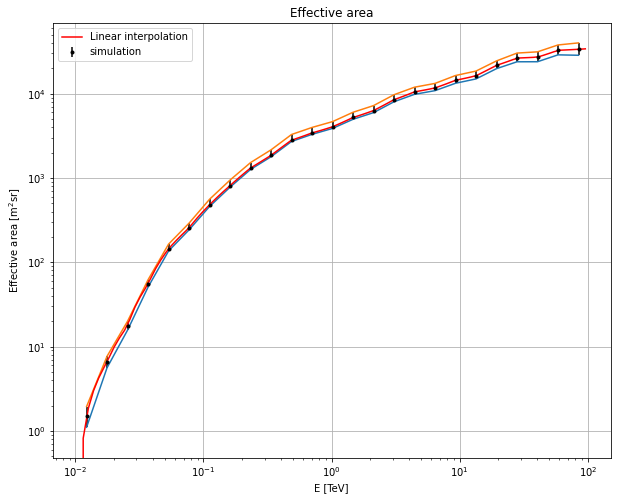

In [20]:
fig = plt.figure(figsize=(10,8))
bin_centers = 0.5 * (e_binning[1:] + e_binning[:-1])
plt.errorbar(bin_centers, ea,
             yerr=[eal, eah],
             fmt='.', color='black', label="simulation")
plt.plot(bin_centers, ea-eal)
plt.plot(bin_centers, ea+eah)


eff_area_interpolated_1 = interp1d(bin_centers, ea, fill_value='extrapolate')
eff_area_interpolated_2 = interp1d(bin_centers, ea, kind='quadratic', fill_value='extrapolate')
eff_area_interpolated_3 = interp1d(bin_centers, ea, kind='cubic', fill_value='extrapolate')
energy_smooth = np.logspace(-2, 2, 100)
energy_centers_smooth = 0.5 * (energy_smooth[1:] + energy_smooth[:-1])
plt.plot(energy_centers_smooth, eff_area_interpolated_1(energy_centers_smooth), 'r-', label="Linear interpolation")
#plt.plot(energy_centers_smooth, eff_area_interpolated_2(energy_centers_smooth), 'g-', label="Quadratic interpolation")
#plt.plot(energy_centers_smooth, eff_area_interpolated_3(energy_centers_smooth), 'b-', label="Cubic interpolation")

plt.title('Effective area')
plt.ylabel('Effective area [m$^2$sr]')
plt.xlabel('E [TeV]')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()

Above is the effective area as a function of energy. The upper and lower lines correspond
to the confidence interval.

## 4. Calculation of trigger rates

The trigger rates are estimated from the convolution of the effective area with the cosmic rays (P + He) flux.
The cell below gives the all particles spectrum from PDG

In [21]:
def differential_rate(energy, func):
    result = 0.096*pow(energy, -2.7)*func(energy)
    if result < 0: result = 0
    return result

So a first approximation can be given by the convolution of the flux above with the effective area. 
The result should be multiplied by 1.5 in order to account for the heavier elements as well (the effective
area was calculated only for protons). A more realistic approach is to calculate the effective areas for protons 
and for Helium, convolute them with their corresponding fluxes, and then add the results. 

The flux for protons, as was measured by DAMPE, can be found at
[https://arxiv.org/abs/1909.12860](https://arxiv.org/abs/1909.12860)

DAMPE observed a hardening of the spectrum at few hundreds GeV and a softening after 10 TeV. The two areas 
were best fitted by a smooth broken power law.

In [22]:
# Import hard DAMPE spectrum (0.1 - 6.3 TeV) for Protons
def DAMPE_hard(energy, func): 
    result = (0.0758*pow(energy, -2.772) * pow((1 + pow((energy/0.48),5.0)), 0.0346))*func(energy)    
    if result < 0: result = 0
    return result 

In [23]:
# Import soft DAMPE spectrum (6.3 - 100 TeV) for Protons
def DAMPE_soft(energy, func):
    result = (0.0868*pow(energy, -2.6) * pow((1 + pow((energy/13.6),5.0)), -0.05))*func(energy)
    if result < 0: result = 0
    return result    

In the cells below we import the Helium flux as measured by DAMPE
[https://arxiv.org/pdf/2105.09073.pdf](https://arxiv.org/pdf/2105.09073.pdf)

In [39]:
# Import hard DAMPE spectrum for Helium (0.01 - 6.8 TeV)
def DAMPE_hard_He(energy, func):
    result = (0.0608*pow(energy, -2.68) * pow((1 + pow((energy/1.25),3.6)), 0.05))*func(energy)
    if result < 0: result = 0
    return result    

In [40]:
# Import soft DAMPE spectrum for Helium (6.8 - 100 TeV)
def DAMPE_soft_He(energy, func):
    result = (0.0471*pow(energy, -2.41) * pow((1 + pow((energy/34.4),5)), -0.102))*func(energy)   
    if result < 0: result = 0
    return result   

Below we calculate the trigger rate per threshold for protons. The integration over energy is splitted in three
parts, each one corresponding to the flux in the giver energy range.

In [31]:
def rate_from_diff_trig_prob(probfile):
    ea, eal, eah, energy_binning = eff_area_from_trigger_probability(probfile)
    #print('effective area',ea,'eal',eal,'eah',eah)
    #print("eal", eal)
    #print('length',len(eal))
    #print("eah", eah)    
    bin_centers = 0.5 * (energy_binning[1:] + energy_binning[:-1])
    eff_area_interpolated = interp1d(bin_centers, ea, fill_value='extrapolate')
    eff_area_interpolated_low = interp1d(bin_centers, ea-eal, fill_value='extrapolate')
    eff_area_interpolated_high = interp1d(bin_centers, ea+eah, fill_value='extrapolate')

    # rate from pyirf spectrum law, 10 GeV < E < 100 GeV
    rate_pl, err = quad(differential_rate, 0.01, 0.1, args=(eff_area_interpolated), limit=100)
    rate_pl_low, err = quad(differential_rate, 0.01, 0.1, args=(eff_area_interpolated_low), limit=100)
    rate_pl_high, err = quad(differential_rate, 0.01, 0.1, args=(eff_area_interpolated_high), limit=100)
    
    # rate from DAMPE SBPL soft, 100 GeV < E < 6.3 TeV    
    rate_soft, err = quad(DAMPE_hard, 0.1, 1, args=(eff_area_interpolated), limit=100)
    rate_soft_low, err = quad(DAMPE_hard, 0.1, 1, args=(eff_area_interpolated_low), limit=100)
    rate_soft_high, err = quad(DAMPE_hard, 0.1, 1, args=(eff_area_interpolated_high), limit=100)    

    # rate from DAMPE SBPL hard, 6.3 TeV < E < 100 TeV        
    rate_hard, err = quad(DAMPE_soft, 1, 100, args=(eff_area_interpolated), limit=100)
    rate_hard_low, err = quad(DAMPE_soft, 1, 100, args=(eff_area_interpolated_low), limit=100)
    rate_hard_high, err = quad(DAMPE_soft, 1, 100, args=(eff_area_interpolated_high), limit=100)    

    rate = rate_pl + rate_soft + rate_hard
    rate_low = rate_pl_low + rate_pl_low + rate_hard_low
    rate_high = rate_pl_high + rate_soft_high + rate_hard_high
    
    return rate, rate_low, rate_high

data = []

for filename in glob.glob('/fefs/aswg/workspace/georgios.voutsinas/Protons/EffectiveAreas/*.npz'):
    threshold = int(filename.split('_')[-1][:-4])
    rate, rate_low, rate_high = rate_from_diff_trig_prob(filename)
    data.append({'threshold': threshold, 'rate': rate, 'rate_low': rate_low, 'rate_high': rate_high})
df_protons = pd.DataFrame.from_records(data)
df_protons.head()

/tmp/ipykernel_33934/860062345.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rate_soft, err = quad(DAMPE_hard, 0.1, 1, args=(eff_area_interpolated), limit=100)
/tmp/ipykernel_33934/860062345.py:19: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rate_soft_low, err = quad(DAMPE_hard, 0.1, 1, args=(eff_area_interpolated_low), limit=100)
/tmp/ipykernel_33934/860062345.py:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rate_soft_high, err = quad(DAMPE_hard, 0.1, 1, args=(eff_area_interpolated_high), limit=100)
/tmp/ipykernel_33934/860062345.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which preve

threshold          rate      rate_low     rate_high
0        470   2565.104849   2102.913558   3052.752202
1        800   1393.702192   1001.361780   1694.201386
2        490   2463.645561   1989.061560   2939.203754
3         90  23035.470627  29241.604394  25525.503310
4        180   8609.210012   9289.250146   9775.324699

In [32]:
df_protons.sort_values(('threshold'), inplace=True)
df_protons = df_protons.reset_index(drop=True)
df_protons.head(20)

threshold           rate       rate_low      rate_high
0          10  348543.334986  536576.023673  377250.784182
1          20  192773.425898  290025.726933  208953.869689
2          30  111720.818202  163114.549957  121482.918401
3          40   74055.572089  105480.872097   80757.055568
4          50   54080.171824   75273.589723   59193.210724
5          60   41076.149417   55570.727939   45110.394755
6          70   33155.483669   44093.303354   36521.363651
7          80   27133.289044   35128.801821   29979.078824
8          90   23035.470627   29241.604394   25525.503310
9         100   19664.561652   24443.927781   21879.150060
10        110   17146.638445   20978.893938   19107.359957
11        120   15458.693305   18687.312261   17280.384259
12        130   13706.899687   16235.169063   15366.886991
13        140   12313.495510   14170.446715   13849.499028
14        150   11144.771551   12707.419594   12560.558381
15        160   10207.882076   11420.487858   11539.502213
16        170    9342.203817   10307.953135   10589.367455
17        180    8609.210012    9289.250146    9775.324699
18        190    8011.679713    8446.925457    9123.986096
19        200    7497.489613    7845.324916    8562.776255

Below we repeat the same procedure for Helium

In [47]:
def rate_from_diff_trig_prob_He(probfile):
    ea, eal, eah, energy_binning = eff_area_from_trigger_probability(probfile)
    #print('effective area',ea,'eal',eal,'eah',eah)
    #print("eal", eal)
    #print('length',len(eal))
    #print("eah", eah)    
    bin_centers = 0.5 * (energy_binning[1:] + energy_binning[:-1])
    eff_area_interpolated = interp1d(bin_centers, ea, fill_value='extrapolate')
    eff_area_interpolated_low = interp1d(bin_centers, ea-eal, fill_value='extrapolate')
    eff_area_interpolated_high = interp1d(bin_centers, ea+eah, fill_value='extrapolate')

    # rate from DAMPE SBPL hard, 100 GeV < E < 6.8 TeV    
    rate_soft, err = quad(DAMPE_hard_He, 0.1, 6.8, args=(eff_area_interpolated), limit=100)
    rate_soft_low, err = quad(DAMPE_hard_He, 0.1, 6.8, args=(eff_area_interpolated_low), limit=100)
    rate_soft_high, err = quad(DAMPE_hard_He, 0.1, 6.8, args=(eff_area_interpolated_high), limit=100)    

    # rate from DAMPE SBPL hard, 6.8 TeV < E < 100 TeV        
    rate_hard, err = quad(DAMPE_soft_He, 6.8, 100, args=(eff_area_interpolated), limit=100)
    rate_hard_low, err = quad(DAMPE_soft_He, 6.8, 100, args=(eff_area_interpolated_low), limit=100)
    rate_hard_high, err = quad(DAMPE_soft_He, 6.8, 100, args=(eff_area_interpolated_high), limit=100)    

    rate = rate_soft + rate_hard
    rate_low = rate_soft_low + rate_hard_low
    rate_high = rate_soft_high + rate_hard_high
    
    return rate, rate_low, rate_high

dataHe = []

for filename in glob.glob('/fefs/aswg/workspace/georgios.voutsinas/Helium/EffectiveAreas/*.npz'):
    threshold = int(filename.split('_')[-1][:-4])
    rate, rate_low, rate_high = rate_from_diff_trig_prob_He(filename)
    dataHe.append({'threshold': threshold, 'rate': rate, 'rate_low': rate_low, 'rate_high': rate_high})
df_helium = pd.DataFrame.from_records(dataHe)
df_helium.head()

/tmp/ipykernel_33934/2436308610.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rate_soft, err = quad(DAMPE_hard_He, 0.1, 6.8, args=(eff_area_interpolated), limit=100)
/tmp/ipykernel_33934/2436308610.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rate_soft_low, err = quad(DAMPE_hard_He, 0.1, 6.8, args=(eff_area_interpolated_low), limit=100)
/tmp/ipykernel_33934/2436308610.py:15: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rate_soft_high, err = quad(DAMPE_hard_He, 0.1, 6.8, args=(eff_area_interpolated_high), limit=100)
/tmp/ipykernel_33934/2436308610.py:18: IntegrationWarning: The occurrence of roundoff error is de

threshold         rate     rate_low    rate_high
0        470   542.282591   485.418834   644.971386
1        800   296.809245   254.795453   367.435158
2        490   509.312447   454.502645   607.361476
3         90  4097.812462  3928.803548  4540.793135
4        180  1679.905403  1575.681606  1906.161477

In [48]:
df_helium.sort_values(('threshold'), inplace=True)
df_helium = df_helium.reset_index(drop=True)
df_helium.head(20)

threshold          rate      rate_low     rate_high
0          10  47946.377346  47357.964755  51825.517005
1          20  27650.650412  27199.763701  29933.482928
2          30  16911.713108  16561.249557  18371.399215
3          40  11641.822562  11351.712042  12686.305812
4          50  11641.822562  11351.712042  12686.305812
5          60   6837.739557   6617.694257   7505.045644
6          70   5673.806237   5474.511439   6250.120357
7          80   4794.485844   4611.778617   5295.377457
8          90   4097.812462   3928.803548   4540.793135
9         100   3583.418848   3426.897571   3984.403868
10        110   3175.644919   3029.046096   3541.392917
11        120   2828.436563   2690.579613   3164.790640
12        130   2554.475434   2424.068229   2864.254919
13        140   2312.768287   2188.986440   2598.869382
14        150   2110.709141   1993.001110   2382.740180
15        160   1945.116565   1832.403837   2197.571636
16        170   1807.539218   1698.465397   2047.382191
17        180   1679.905403   1575.681606   1906.161477
18        190   1572.699712   1472.003979   1789.700011
19        200   1502.394631   1404.057366   1712.159127

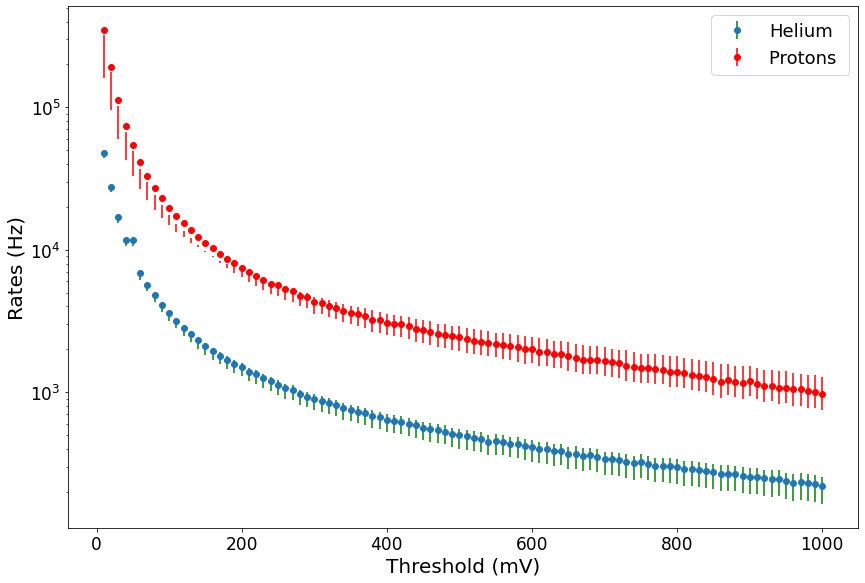

In [49]:
# Plot Helium rate
fig2, ax2 = plt.subplots()
fig2.tight_layout()
fig2.set_size_inches(12.5, 8.5)
plt.rc('legend',fontsize=18)
ax2.set_ylabel('Rates (Hz)',fontsize=20)
ax2.set_xlabel('Threshold (mV)',fontsize=20)
ax2.tick_params(axis='x', labelsize=17)
ax2.tick_params(axis='y', labelsize=17)
asymmetric_error_he = np.array(list(zip(df_helium['rate_high']-df_helium['rate'], df_helium['rate']-df_helium['rate_low']))).T
asymmetric_error_p = np.array(list(zip(df_protons['rate_high']-df_protons['rate'], df_protons['rate']-df_protons['rate_low']))).T


ax2.errorbar(pd.to_numeric(df_helium['threshold']), pd.to_numeric(df_helium['rate']), 
            yerr=asymmetric_error_he,
            fmt='o', ecolor='g', capthick=2,label="Helium")
ax2.errorbar(pd.to_numeric(df_protons['threshold']), pd.to_numeric(df_protons['rate']), 
            yerr=asymmetric_error_p,
            fmt='o', color='r', ecolor='r', capthick=2,label="Protons ")
leg = ax2.legend()
plt.yscale('log')
#fig2.savefig('Helium_vs_protons.png')

## 5. Putting everything together

Now let's add the rates come from Protons, Helium and NSB together. Let's first create a dataframe
from the NSB rates file

In [50]:
nsb_file_csv = '/fefs/aswg/workspace/mykhailo.dalchenko/trigger_studies/trigger_scan_prod5_default_nsb_only_asum_thr_10_1000_step_10_high_stat/output/mc.csv'
sim_nsb = pd.read_csv(nsb_file_csv)
sim_nsb.drop('Unnamed: 0', axis=1, inplace=True)
sim_nsb.head()

nsb rate  threshold  simulated events  triggered events   camera rate  \
0   0.24586         10            100000            100000  1.365333e+07   
1   0.24586         20            100000            100000  1.365333e+07   
2   0.24586         30            100000            100000  1.365333e+07   
3   0.24586         40            100000            100000  1.365333e+07   
4   0.24586         50            100000            100000  1.365333e+07   

   number of fired sectors  trg sct 0 rate  trg sct 1 rate  trg sct 2 rate  \
0                473.96349    1.365251e+07    1.365251e+07    1.365279e+07   
1                472.75630    1.361715e+07    1.361688e+07    1.362220e+07   
2                459.91056    1.323855e+07    1.323281e+07    1.322148e+07   
3                406.53210    1.163523e+07    1.170118e+07    1.168971e+07   
4                300.77503    8.813636e+06    8.663996e+06    8.752469e+06   

   trg sct 3 rate  ...  trg sct 464 rate  trg sct 465 rate  trg sct 466 rate  \
0    1.365265e+07  ...      1.365265e+07      1.365210e+07      1.365292e+07   
1    1.361374e+07  ...      1.361661e+07      1.361811e+07      1.362302e+07   
2    1.323622e+07  ...      1.328142e+07      1.327063e+07      1.328319e+07   
3    1.153242e+07  ...      1.182938e+07      1.186652e+07      1.191335e+07   
4    8.646383e+06  ...      8.699767e+06      8.815957e+06      8.915627e+06   

   trg sct 467 rate  trg sct 468 rate  trg sct 469 rate  trg sct 470 rate  \
0      1.365238e+07      1.365265e+07      1.365210e+07      1.365224e+07   
1      1.361811e+07      1.362275e+07      1.362275e+07      1.361988e+07   
2      1.327978e+07      1.327596e+07      1.328305e+07      1.328852e+07   
3      1.186939e+07      1.182966e+07      1.188045e+07      1.183403e+07   
4      8.898423e+06      8.771311e+06      8.855415e+06      8.910438e+06   

   trg sct 471 rate  trg sct 472 rate  trg sct 473 rate  
0      1.365251e+07      1.365265e+07      1.365183e+07  
1      1.362234e+07      1.362166e+07      1.361975e+07  
2      1.330340e+07      1.324879e+07      1.325274e+07  
3      1.184249e+07      1.176125e+07      1.186447e+07  
4      8.806673e+06      9.072640e+06      8.983484e+06  

[5 rows x 480 columns]

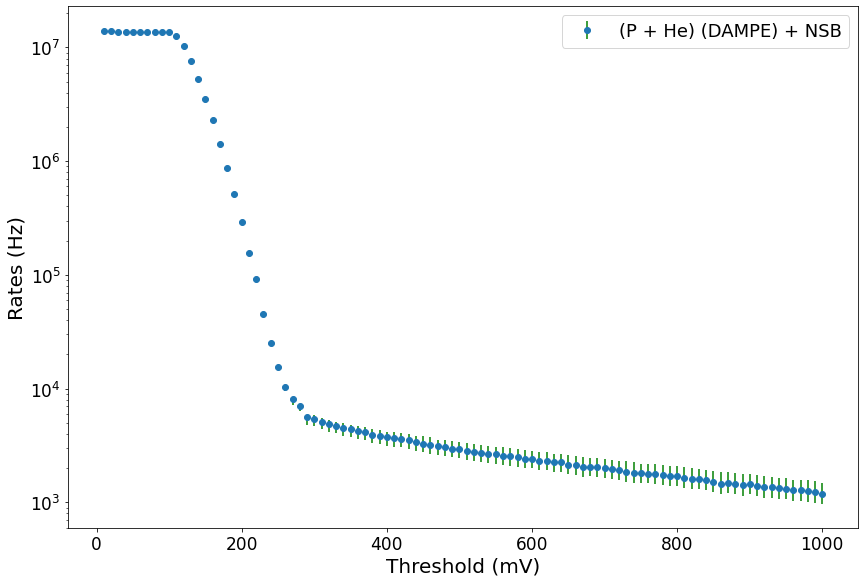

In [51]:
# Now plot the sum
fig, ax = plt.subplots()
fig.tight_layout()
fig.set_size_inches(12.5, 8.5)
plt.rc('legend',fontsize=18)
ax.set_ylabel('Rates (Hz)',fontsize=20)
ax.set_xlabel('Threshold (mV)',fontsize=20)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=17)

ax.errorbar(pd.to_numeric(df_protons['threshold']), pd.to_numeric(sim_nsb['camera rate']) 
            + pd.to_numeric(df_protons['rate'])
            + pd.to_numeric(df_helium['rate']),
            yerr = np.sqrt(asymmetric_error_he**2 + asymmetric_error_p**2),
            fmt='o', ecolor='g', capthick=2,label="(P + He) (DAMPE) + NSB")
leg = ax.legend()
plt.yscale('log')
fig.savefig('Alltogether.png')

## 6. Calculate the per sector rate

In order to compare simulation with real data, we have to extract the per sector rate from the simulation.
To do so, we need to extract the camera (total) rate and the average per sector rate for each threshold.
This can be achieved by running the script compute_per_sector_trigger_rates_list.

The 2 required arguments are:
 - the path to the toml configuration file
 - the file lists created at [lists](#lists)
 
The user should modify the output folder in the toml file.

In [52]:
# Calculate average NSB rate
sim_nsb_sector_rates = sim_nsb.drop(['nsb rate',
                                     'threshold',
                                     'camera rate',
                                     'simulated events',
                                     'triggered events',
                                     'number of fired sectors'],
                                    axis=1, inplace=False)
average_nsb_sector = sim_nsb_sector_rates.mean(axis=1)

In [53]:
# Calculate per sector rate for Protons
thresholds = []
rates = []
points = []
lines = []
for i in sorted(glob.glob(f'/home/georgios.voutsinas/ws/Protons/Per_Sector/rate_per_sector_threshold_*.txt')):
    with open(i, 'r') as f:
        content = f.read().splitlines()
        threshold = int(content[0].split(' ')[1])/4.8
        camera_triggered = int(content[1].split(' ')[2])
        average_sector_triggered = float(content[2].split(' ')[3])
        sigma_sector_triggered = float(content[3].split(' ')[3])
        relative_sector_rate = average_sector_triggered/camera_triggered
        relative_sector_rate_up = (average_sector_triggered + sigma_sector_triggered)/camera_triggered
        relative_sector_rate_down = (average_sector_triggered - sigma_sector_triggered)/camera_triggered
        lines.append([threshold,
                      camera_triggered,
                      average_sector_triggered,
                      sigma_sector_triggered,
                      relative_sector_rate,
                      relative_sector_rate_up,
                      relative_sector_rate_down])
                
sim_proton_sector_df = pd.DataFrame(lines, columns = ['threshold',
                                                  'Camera triggered',
                                                  'Average sector triggered',
                                                  'Sigma sector triggered',
                                                  'Relative sector rate',
                                                  'Relative sector rate up',
                                                  'Relative sector rate down'])
sim_proton_sector_df.sort_values(by='threshold', inplace=True)
sim_proton_sector_df = sim_proton_sector_df.reset_index(drop=True)
sim_proton_sector_df.head()

threshold  Camera triggered  Average sector triggered  \
0   2.083333            198036               6815.105485   
1   4.166667            112541               3189.082278   
2   6.250000             67242               1830.938819   
3   8.333333             52707               1439.514768   
4  10.416667             38361               1048.031646   

   Sigma sector triggered  Relative sector rate  Relative sector rate up  \
0              219.001737              0.034413                 0.035519   
1              111.945980              0.028337                 0.029332   
2               62.945111              0.027229                 0.028165   
3               51.466723              0.027312                 0.028288   
4               38.537792              0.027320                 0.028325   

   Relative sector rate down  
0                   0.033308  
1                   0.027342  
2                   0.026293  
3                   0.026335  
4                   0.026316

In [55]:
# now Helium
lines2 = []
for i in sorted(glob.glob(f'/home/georgios.voutsinas/ws/Helium/Per_Sector/rate_per_sector_threshold_*.txt')):
    with open(i, 'r') as f:
        content = f.read().splitlines()
        threshold = int(content[0].split(' ')[1])/4.8
        camera_triggered = int(content[1].split(' ')[2])
        average_sector_triggered = float(content[2].split(' ')[3])
        sigma_sector_triggered = float(content[3].split(' ')[3])
        relative_sector_rate = average_sector_triggered/camera_triggered
        relative_sector_rate_up = (average_sector_triggered + sigma_sector_triggered)/camera_triggered
        relative_sector_rate_down = (average_sector_triggered - sigma_sector_triggered)/camera_triggered
        lines2.append([threshold,
                      camera_triggered,
                      average_sector_triggered,
                      sigma_sector_triggered,
                      relative_sector_rate,
                      relative_sector_rate_up,
                      relative_sector_rate_down])
                
sim_helium_sector_df = pd.DataFrame(lines2, columns = ['threshold',
                                                  'Camera triggered',
                                                  'Average sector triggered',
                                                  'Sigma sector triggered',
                                                  'Relative sector rate',
                                                  'Relative sector rate up',
                                                  'Relative sector rate down'])
sim_helium_sector_df.sort_values(by='threshold', inplace=True)
sim_helium_sector_df = sim_helium_sector_df.reset_index(drop=True)
sim_helium_sector_df.head()

threshold  Camera triggered  Average sector triggered  \
0   2.083333             73281               2738.094937   
1   4.166667             43986               1347.219409   
2   6.250000             28013                826.742616   
3   8.333333             19857                582.531646   
4  10.416667             15103                444.584388   

   Sigma sector triggered  Relative sector rate  Relative sector rate up  \
0               91.201644              0.037364                 0.038609   
1               47.326302              0.030628                 0.031704   
2               34.525860              0.029513                 0.030745   
3               24.133508              0.029336                 0.030552   
4               21.262630              0.029437                 0.030845   

   Relative sector rate down  
0                   0.036120  
1                   0.029552  
2                   0.028280  
3                   0.028121  
4                   0.028029

In [56]:
sim_proton_camera_rate = df_protons['rate']
sim_helium_camera_rate = df_helium['rate']

sim_proton_camera_sector_rate = [a * b for a,b in zip(sim_proton_camera_rate, 
                                sim_proton_sector_df['Relative sector rate'])]
sim_helium_camera_sector_rate = [a * b for a,b in zip(sim_helium_camera_rate, 
                                sim_helium_sector_df['Relative sector rate'])]

(0.1, 100000000)

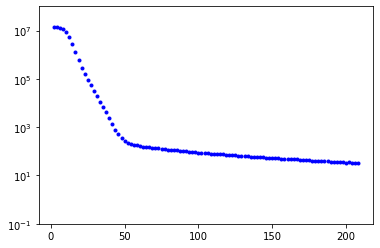

In [57]:
total_per_sector_rate_mc = [n + p + He for n, p, He in zip(average_nsb_sector, sim_proton_camera_sector_rate, sim_helium_camera_sector_rate)]
plt.plot(sim_proton_sector_df['threshold'], total_per_sector_rate_mc, 'bo', linestyle='None', markersize = 3.0)
plt.yscale('log')
plt.ylim(0.1, 10**8)

And below we save the simulated per sector rate to a dataframe in pickle, so we can import it and compare with
real data

In [ ]:
import pickle

dflist = [average_nsb_sector, sim_proton_camera_sector_rate, sim_helium_camera_sector_rate, sim_proton_sector_df]
with open('ofile.pkl', 'wb') as filehandle:
    pickle.dump(dflist, filehandle)